In [111]:
import pandas as pd
import numpy as np
import datetime
from IPython.display import display
from statsmodels.stats.proportion import proportions_ztest
import matplotlib.pyplot as plt
import seaborn as sns;
from matplotlib.patches import Patch

%matplotlib inline

pd.options.display.max_columns = None


# Load experiment Design data

## 1. Load Email list

In [112]:
# hard code Email lists. Email ID is the index of the Email in the list

PO_number_list = ['ml_funding_enables_investing','ml_investing_starts_here','ml_explore_the_app_investing',
                  'ml_funding_faq','ml_user_clustering_emails_fracs','ml_funding_is_safe','ml_picking_an_investment', 
                  'ml_investing_101','ml_diversified_portfolio','ml_explore_the_app_list']

## 2. Load user segment information

In [113]:
segment_group_init_df = pd.read_csv('./data/sample_segment_groups.csv')
segment_group_init_df = segment_group_init_df.drop(columns='Unnamed: 0')
segment_group_init_df

,group_id,approved_within6M_flag,link_flag,recent_activity_flag(20days),5day_trade_flag,user_uuid,group_name
0,0,False,False,False,False,4418550,ML_unfund_exp_control
1,1,False,False,True,False,314921,20D_Act
2,2,False,False,True,True,409786,20D_Act-5D_Act
3,3,False,True,False,False,941341,link
4,4,False,True,True,False,102541,link-20D_Act
5,5,False,True,True,True,136513,link-20D_Act-5D_Act
6,6,True,False,False,False,814827,6M_App
7,7,True,False,True,False,218938,6M_App-20D_Act
8,8,True,False,True,True,233445,6M_App-20D_Act-5D_Act
9,9,True,True,False,False,127008,6M_App-link


## 3. Load sampled users with Email delivery orders for the experiment

In [114]:
sample_exp_df = pd.read_csv('./data/sample_uuid_email_order.csv')
sample_exp_df.head()

,user_uuid,group_id,group_name,order_0,order_1,order_2,order_3,order_4,order_5,order_6,order_7,order_8,order_9
0,id_2623238174270264636,0,ML_unfund_exp_control_D,5,7,3,4,8,9,0,1,6,2
1,id_14752263936159847779,0,ML_unfund_exp_control_D,3,1,6,0,5,9,4,8,7,2
2,id_3723259155072282145,0,ML_unfund_exp_control_D,8,7,3,6,1,4,2,9,0,5
3,id_9433964625840258739,0,ML_unfund_exp_control_D,1,8,0,6,5,7,4,9,3,2
4,id_17251718038176858460,0,ML_unfund_exp_control_D,6,1,8,0,7,3,5,2,9,4


In [6]:
sample_exp_df.shape

(480000, 13)

# load Email Events

In [115]:
email_event_summary_df = pd.read_csv('./data/email_events.csv')

In [116]:
email_event_summary_df.head()

,stitch_email_events.category,stitch_email_events.dt_date,user_uuid,event,reason,stitch_email_events.count_events
0,"[""ml_picking_an_investment"",""post-office""]",2020-12-30,id_13999943483500367320,open,NaN,1
1,"[""ml_explore_the_app_investing"",""post-office""]",2020-12-30,id_3965698071238241409,open,NaN,1
2,"[""ml_picking_an_investment"",""post-office""]",2020-12-30,id_9648414115970654735,open,NaN,1
3,"[""ml_investing_starts_here"",""post-office""]",2020-12-30,id_8951454012305223869,open,NaN,1
4,"[""ml_investing_101"",""post-office""]",2020-12-30,id_8180145303883056882,open,NaN,2


In [117]:
email_event_summary_df['event'].unique()

array(['open', 'unsubscribe', 'spamreport', 'deferred', 'bounce',
       'processed', 'delivered', 'dropped'], dtype=object)

# load current user status

In [118]:
user_event_df = pd.read_csv('./data/user_events.csv')
user_event_df.head()

,user_uuid,group_name,ml_funding_enables_investing,ml_investing_starts_here,ml_explore_the_app_investing,ml_funding_faq,ml_user_clustering_emails_fracs,ml_funding_is_safe,ml_picking_an_investment,ml_investing_101,ml_diversified_portfolio,ml_explore_the_app_list,approved_at,first_funded_at,first_linked_bank_account_at,5d_trading_avg_event_count,2d_non_trading_avg_event_count,20d_trading_avg_event_count,8d_non_trading_avg_event_count,1d_trading_avg_event_count,1d_non_trading_avg_event_count,num_received_email
0,id_2623238174270264636,ML_unfund_exp_control_D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-01-14 16:31:59.295,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,id_14752263936159847779,ML_unfund_exp_control_D,delivered,delivered,delivered,delivered,delivered,delivered,delivered,delivered,open,delivered,2019-01-29 16:22:26.866,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9
2,id_3723259155072282145,ML_unfund_exp_control_D,delivered,delivered,open,open,open,delivered,delivered,delivered,delivered,open,2019-02-01 00:01:48.853,2020-12-04 20:41:55.146,2020-12-04 20:41:37.842,53.0,NaN,171.0,NaN,NaN,NaN,6
3,id_9433964625840258739,ML_unfund_exp_control_D,delivered,delivered,delivered,delivered,delivered,delivered,delivered,delivered,delivered,delivered,2020-03-17 21:02:43.906,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10
4,id_17251718038176858460,ML_unfund_exp_control_D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-12-30 18:23:15.726,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


# Calculate Metrics for treatment groups


## 1. Email open rate

In [119]:
delivered_count_df = user_event_df.loc[:,['group_name']+PO_number_list]
for e in PO_number_list:
    delivered_count_df[e] = delivered_count_df[e].notnull()
    
delivered_count_df = delivered_count_df.groupby('group_name').sum().reset_index()

In [120]:
delivered_count_df.head(50)

,group_name,ml_funding_enables_investing,ml_investing_starts_here,ml_explore_the_app_investing,ml_funding_faq,ml_user_clustering_emails_fracs,ml_funding_is_safe,ml_picking_an_investment,ml_investing_101,ml_diversified_portfolio,ml_explore_the_app_list
0,20D_Act-5D_Act_D,19230,19257,19252,19251,19253,19251,19271,19265,19241,19249
1,20D_Act-5D_Act_W,17412,17292,17346,17323,17299,17365,17319,17294,17347,17294
2,20D_Act_D,19062,19040,19054,19055,19060,19050,19056,19050,19052,19042
3,20D_Act_W,17202,17132,17148,17107,17052,17156,17108,17097,17156,17094
4,6M_App-20D_Act-5D_Act_D,19290,19285,19268,19289,19283,19285,19270,19282,19308,19273
5,6M_App-20D_Act-5D_Act_W,17409,17325,17383,17344,17305,17393,17357,17333,17377,17342
6,6M_App-20D_Act_D,19048,19037,19037,19050,19051,19041,19039,19052,19065,19031
7,6M_App-20D_Act_W,17205,17101,17113,17096,17046,17141,17118,17096,17150,17091
8,6M_App-link-20D_Act-5D_Act_D,19209,19211,19207,19198,19201,19208,19217,19205,19186,19181
9,6M_App-link-20D_Act-5D_Act_W,17251,17198,17190,17179,17158,17228,17183,17171,17218,17165


In [121]:
open_count_df = user_event_df.loc[:,['group_name']+PO_number_list]
for e in PO_number_list:
    open_count_df[e] = open_count_df[e] == 'open' 
    
open_count_df = open_count_df.groupby('group_name').sum().reset_index()

In [122]:
open_count_df

,group_name,ml_funding_enables_investing,ml_investing_starts_here,ml_explore_the_app_investing,ml_funding_faq,ml_user_clustering_emails_fracs,ml_funding_is_safe,ml_picking_an_investment,ml_investing_101,ml_diversified_portfolio,ml_explore_the_app_list
0,20D_Act-5D_Act_D,3191,3140,3171,5054,3407,3215,3306,3243,3043,3290
1,20D_Act-5D_Act_W,2873,2875,2843,4545,3117,2878,2924,2869,2829,2879
2,20D_Act_D,3464,3455,3487,5108,3650,3501,3545,3476,3524,3520
3,20D_Act_W,3022,3094,3058,4598,3146,3134,3084,3113,3010,3170
4,6M_App-20D_Act-5D_Act_D,3465,3493,3423,4896,3698,3486,3644,3520,3430,3590
5,6M_App-20D_Act-5D_Act_W,3187,3267,3147,4457,3355,3145,3213,3130,3095,3169
6,6M_App-20D_Act_D,3552,3658,3650,4786,3826,3651,3817,3658,3527,3677
7,6M_App-20D_Act_W,3114,3126,3091,4348,3284,3117,3151,3178,3137,3178
8,6M_App-link-20D_Act-5D_Act_D,3899,3876,3931,6054,4133,3943,3918,3913,3796,3896
9,6M_App-link-20D_Act-5D_Act_W,3390,3389,3358,5419,3505,3432,3482,3428,3263,3418


In [126]:
open_rate_df = open_count_df
for e in PO_number_list:
    open_rate_df[e] = open_count_df[e]/delivered_count_df[e]

In [127]:
open_rate_df

,group_name,ml_funding_enables_investing,ml_investing_starts_here,ml_explore_the_app_investing,ml_funding_faq,ml_user_clustering_emails_fracs,ml_funding_is_safe,ml_picking_an_investment,ml_investing_101,ml_diversified_portfolio,ml_explore_the_app_list
0,20D_Act-5D_Act_D,0.165939,0.163058,0.164710,0.262532,0.176959,0.167004,0.171553,0.168336,0.158152,0.170918
1,20D_Act-5D_Act_W,0.165001,0.166262,0.163899,0.262368,0.180184,0.165736,0.168832,0.165896,0.163083,0.166474
2,20D_Act_D,0.181723,0.181460,0.183006,0.268066,0.191501,0.183780,0.186031,0.182467,0.184967,0.184855
3,20D_Act_W,0.175677,0.180598,0.178330,0.268779,0.184494,0.182677,0.180267,0.182079,0.175449,0.185445
4,6M_App-20D_Act-5D_Act_D,0.179627,0.181125,0.177652,0.253823,0.191775,0.180762,0.189102,0.182554,0.177647,0.186271
5,6M_App-20D_Act-5D_Act_W,0.183066,0.188571,0.181039,0.256976,0.193875,0.180820,0.185113,0.180580,0.178109,0.182736
6,6M_App-20D_Act_D,0.186476,0.192152,0.191732,0.251234,0.200829,0.191744,0.200483,0.192001,0.184999,0.193211
7,6M_App-20D_Act_W,0.180994,0.182796,0.180623,0.254328,0.192655,0.181845,0.184075,0.185891,0.182915,0.185946
8,6M_App-link-20D_Act-5D_Act_D,0.202978,0.201759,0.204665,0.315345,0.215249,0.205279,0.203882,0.203749,0.197853,0.203118
9,6M_App-link-20D_Act-5D_Act_W,0.196510,0.197058,0.195346,0.315443,0.204278,0.199211,0.202642,0.199639,0.189511,0.199126


### From the open rate heatmap, we can clearly see the most effective Email is 'ml_funding_faq'. The best user segment group is '6M_App-link-20D_Act-5D_Act_*'

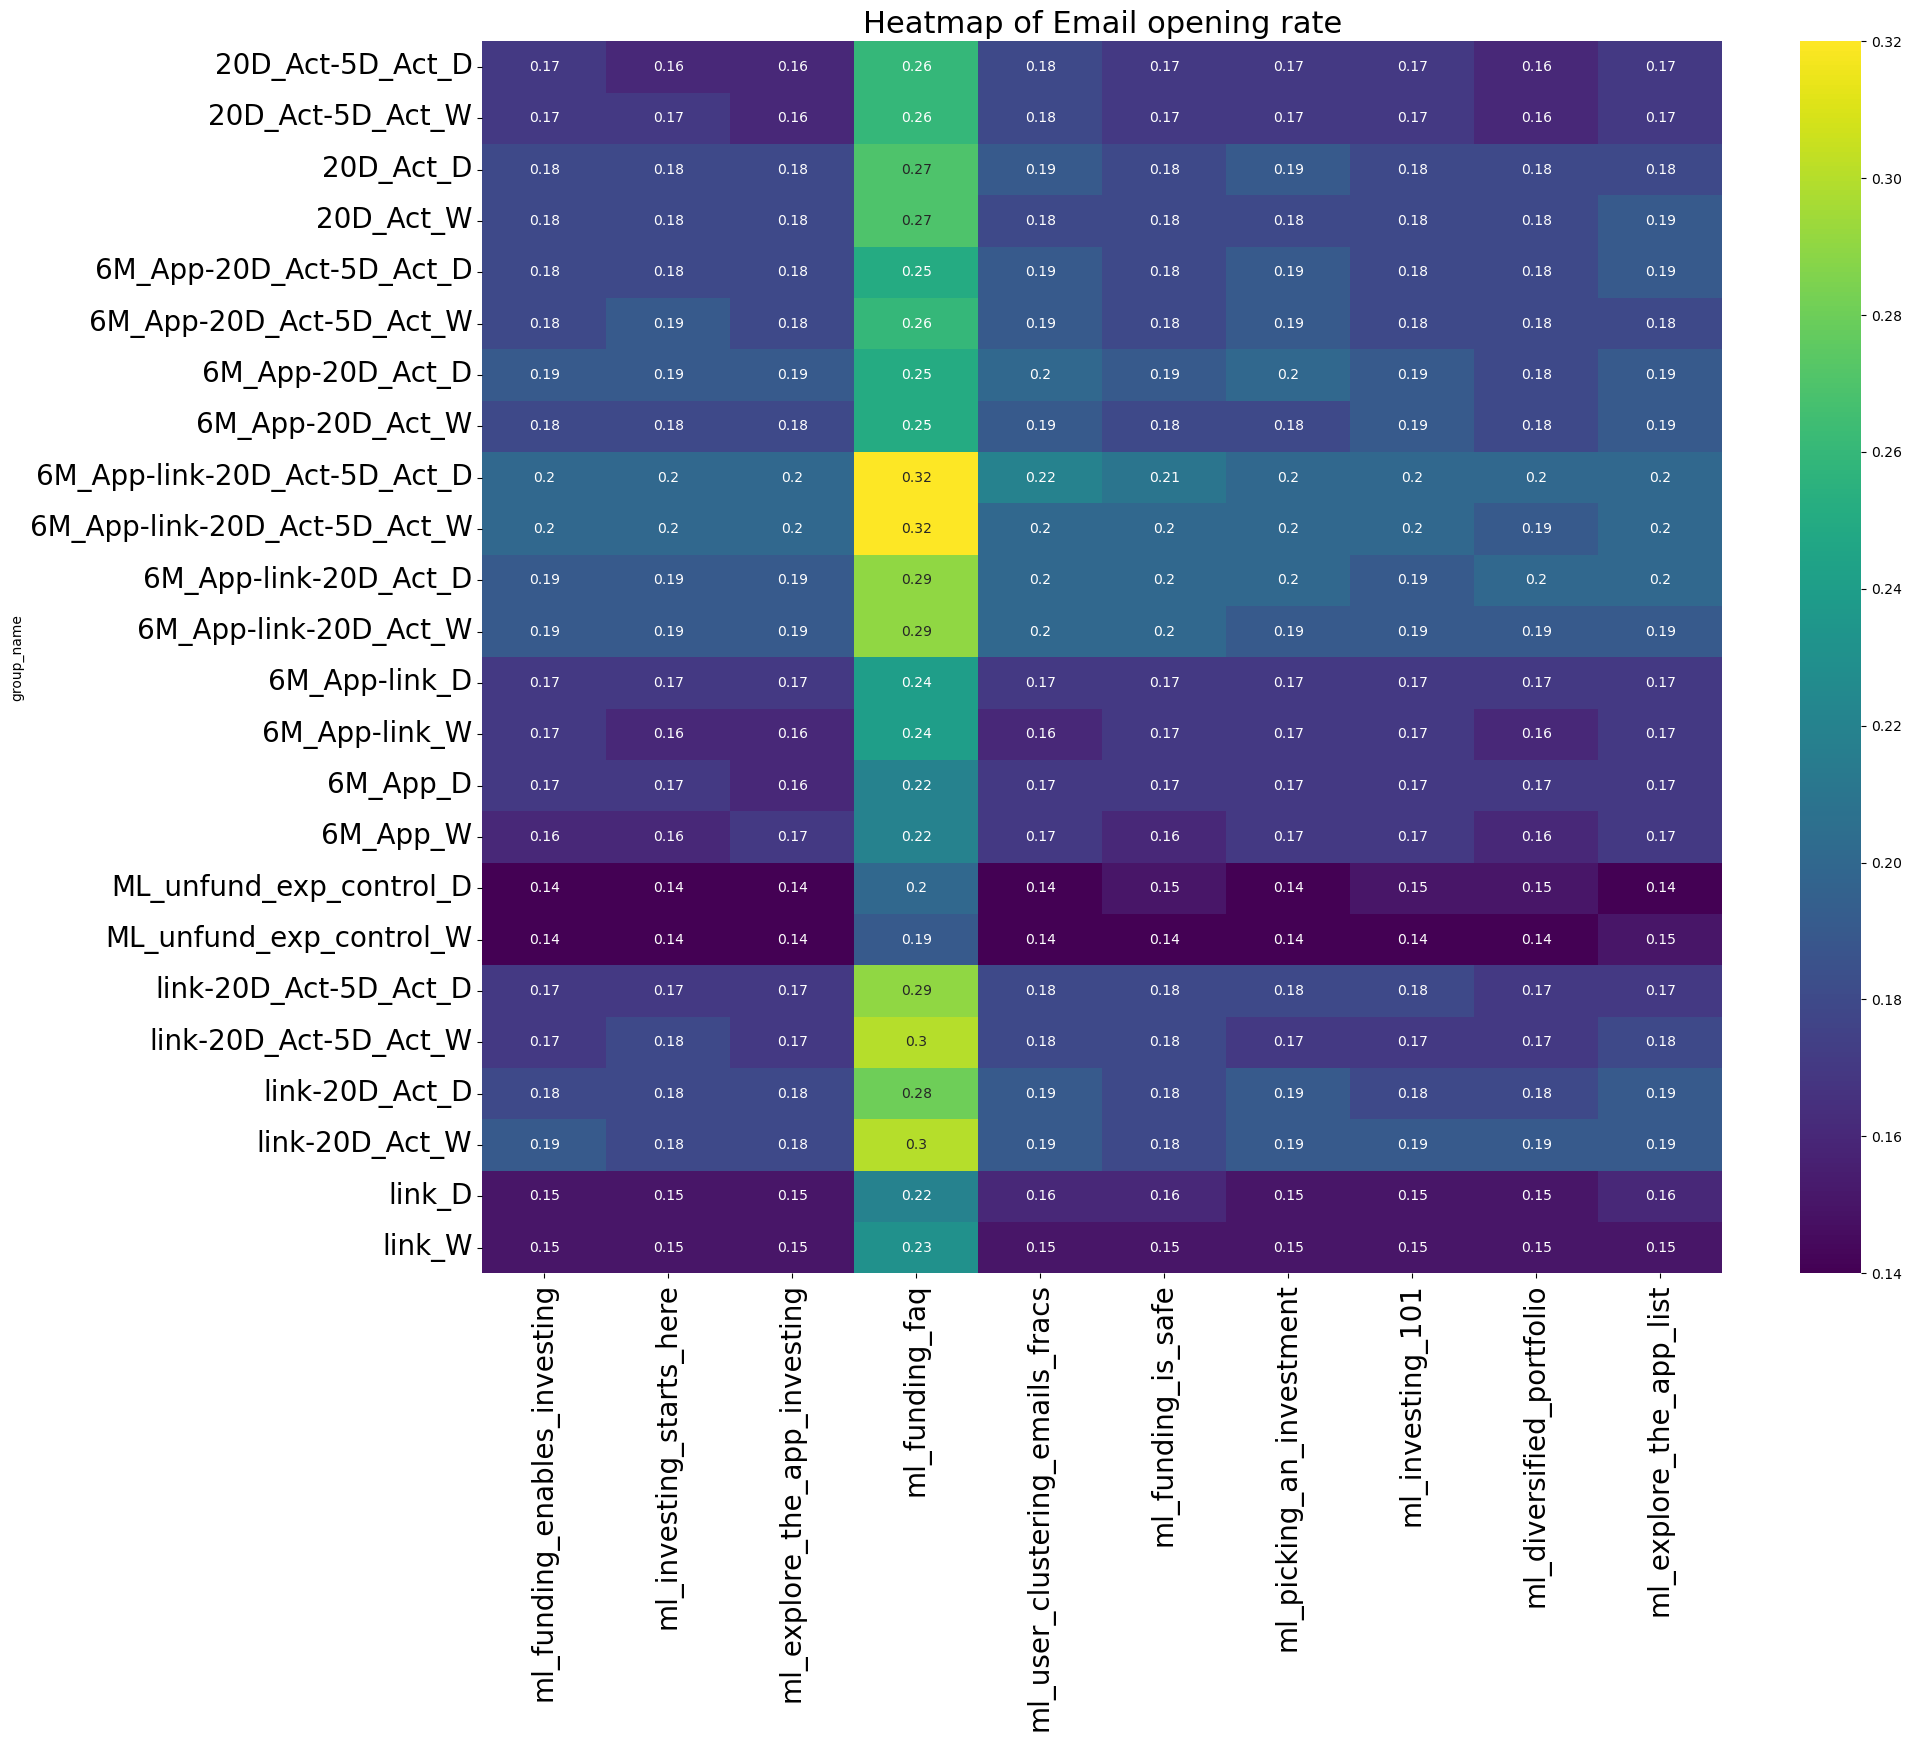

In [128]:
result = open_rate_df.round(2).set_index('group_name')
fig, ax = plt.subplots(figsize=(20, 16))
sns.heatmap(result, annot=True, fmt="g", cmap='viridis')

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('Heatmap of Email opening rate',fontsize=22)
    
    
plt.show()

### Optional: check negative effects, such as 'report spam', 'unsubscribe'. Events such as closing account can be tracked in user activity table.

In [37]:
neg_count_df = user_event_df.loc[:,['group_name']+PO_number_list]
for e in PO_number_list:
    neg_count_df[e] = ((neg_count_df[e] == 'spamreport') | (neg_count_df[e] == 'unsubscribe'))
    
neg_count_df = neg_count_df.groupby('group_name').sum().reset_index()

In [38]:
neg_count_df.head(50)

,group_name,ml_funding_enables_investing,ml_investing_starts_here,ml_explore_the_app_investing,ml_funding_faq,ml_user_clustering_emails_fracs,ml_funding_is_safe,ml_picking_an_investment,ml_investing_101,ml_diversified_portfolio,ml_explore_the_app_list
0,20D_Act-5D_Act_D,2,7,5,7,8,3,11,10,9,8
1,20D_Act-5D_Act_W,2,3,1,7,5,3,1,1,5,2
2,20D_Act_D,4,4,1,5,9,8,9,4,6,7
3,20D_Act_W,7,3,3,3,5,4,2,5,6,1
4,6M_App-20D_Act-5D_Act_D,5,4,3,4,7,4,4,3,3,5
5,6M_App-20D_Act-5D_Act_W,4,5,5,4,5,4,4,6,3,5
6,6M_App-20D_Act_D,4,4,8,5,6,6,4,4,10,2
7,6M_App-20D_Act_W,4,4,7,4,6,6,3,5,4,8
8,6M_App-link-20D_Act-5D_Act_D,10,6,7,6,8,4,8,6,14,9
9,6M_App-link-20D_Act-5D_Act_W,3,3,4,4,5,4,3,5,4,7


## 2. Correlation analysis on open rate

In [46]:
open_rate_flat_df = open_rate_df.copy()
open_rate_flat_df['daily'] = open_rate_flat_df['group_name'].str.contains('_D')
open_rate_flat_df['twice_a_week'] = open_rate_flat_df['group_name'].str.contains('_W')
open_rate_flat_df['group_name'] = open_rate_flat_df['group_name'].str.strip('_D')
open_rate_flat_df['group_name'] = open_rate_flat_df['group_name'].str.strip('_W')

open_rate_flat_df = open_rate_flat_df.merge(segment_group_init_df,how = 'left',on='group_name').drop(['user_uuid'],axis=1)
open_rate_flat_df



,group_name,ml_funding_enables_investing,ml_investing_starts_here,ml_explore_the_app_investing,ml_funding_faq,ml_user_clustering_emails_fracs,ml_funding_is_safe,ml_picking_an_investment,ml_investing_101,ml_diversified_portfolio,ml_explore_the_app_list,daily,twice_a_week,group_id,approved_within6M_flag,link_flag,recent_activity_flag(20days),5day_trade_flag
0,20D_Act-5D_Act,0.165939,0.163058,0.164710,0.262532,0.176959,0.167004,0.171553,0.168336,0.158152,0.170918,True,False,2,False,False,True,True
1,20D_Act-5D_Act,0.165001,0.166262,0.163899,0.262368,0.180184,0.165736,0.168832,0.165896,0.163083,0.166474,False,True,2,False,False,True,True
2,20D_Act,0.181723,0.181460,0.183006,0.268066,0.191501,0.183780,0.186031,0.182467,0.184967,0.184855,True,False,1,False,False,True,False
3,20D_Act,0.175677,0.180598,0.178330,0.268779,0.184494,0.182677,0.180267,0.182079,0.175449,0.185445,False,True,1,False,False,True,False
4,6M_App-20D_Act-5D_Act,0.179627,0.181125,0.177652,0.253823,0.191775,0.180762,0.189102,0.182554,0.177647,0.186271,True,False,8,True,False,True,True
5,6M_App-20D_Act-5D_Act,0.183066,0.188571,0.181039,0.256976,0.193875,0.180820,0.185113,0.180580,0.178109,0.182736,False,True,8,True,False,True,True
6,6M_App-20D_Act,0.186476,0.192152,0.191732,0.251234,0.200829,0.191744,0.200483,0.192001,0.184999,0.193211,True,False,7,True,False,True,False
7,6M_App-20D_Act,0.180994,0.182796,0.180623,0.254328,0.192655,0.181845,0.184075,0.185891,0.182915,0.185946,False,True,7,True,False,True,False
8,6M_App-link-20D_Act-5D_Act,0.202978,0.201759,0.204665,0.315345,0.215249,0.205279,0.203882,0.203749,0.197853,0.203118,True,False,11,True,True,True,True
9,6M_App-link-20D_Act-5D_Act,0.196510,0.197058,0.195346,0.315443,0.204278,0.199211,0.202642,0.199639,0.189511,0.199126,False,True,11,True,True,True,True


In [49]:
open_rate_flat_template_df = open_rate_flat_df.copy()
open_rate_flat_template_df[PO_number_list] = False

open_rate_flat_TF_df = pd.DataFrame()
for e in PO_number_list:
    temp = open_rate_flat_template_df.copy()
    temp[e] = True
    temp['open_rate'] = open_rate_flat_df[e]
    open_rate_flat_TF_df = pd.concat([open_rate_flat_TF_df, temp])

open_rate_flat_TF_df = open_rate_flat_TF_df.reset_index()
open_rate_flat_TF_df = open_rate_flat_TF_df.drop(columns = ['index'])
open_rate_flat_TF_df

,group_name,ml_funding_enables_investing,ml_investing_starts_here,ml_explore_the_app_investing,ml_funding_faq,ml_user_clustering_emails_fracs,ml_funding_is_safe,ml_picking_an_investment,ml_investing_101,ml_diversified_portfolio,ml_explore_the_app_list,daily,twice_a_week,group_id,approved_within6M_flag,link_flag,recent_activity_flag(20days),5day_trade_flag,open_rate
0,20D_Act-5D_Act,True,False,False,False,False,False,False,False,False,False,True,False,2,False,False,True,True,0.165939
1,20D_Act-5D_Act,True,False,False,False,False,False,False,False,False,False,False,True,2,False,False,True,True,0.165001
2,20D_Act,True,False,False,False,False,False,False,False,False,False,True,False,1,False,False,True,False,0.181723
3,20D_Act,True,False,False,False,False,False,False,False,False,False,False,True,1,False,False,True,False,0.175677
4,6M_App-20D_Act-5D_Act,True,False,False,False,False,False,False,False,False,False,True,False,8,True,False,True,True,0.179627
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,link-20D_Act-5D_Act,False,False,False,False,False,False,False,False,False,True,False,True,5,False,True,True,True,0.178259
236,link-20D_Act,False,False,False,False,False,False,False,False,False,True,True,False,4,False,True,True,False,0.186024
237,link-20D_Act,False,False,False,False,False,False,False,False,False,True,False,True,4,False,True,True,False,0.187177
238,link,False,False,False,False,False,False,False,False,False,True,True,False,3,False,True,False,False,0.155905


In [51]:
corr = open_rate_flat_TF_df.drop('group_name', axis=1).corr()

corr = corr.sort_values(by=['open_rate'], ascending =False)
corr['open_rate']

open_rate                          1.000000
ml_funding_faq                     0.793531
recent_activity_flag(20days)       0.450146
group_id                           0.364588
approved_within6M_flag             0.241516
5day_trade_flag                    0.172443
link_flag                          0.160358
daily                              0.026641
ml_user_clustering_emails_fracs   -0.025562
twice_a_week                      -0.026641
ml_picking_an_investment          -0.065907
ml_explore_the_app_list           -0.074458
ml_funding_is_safe                -0.082867
ml_investing_101                  -0.090776
ml_investing_starts_here          -0.098976
ml_funding_enables_investing      -0.114963
ml_explore_the_app_investing      -0.117040
ml_diversified_portfolio          -0.122984
Name: open_rate, dtype: float64

## Summary of Email Open­ Rate Correlations

- **Funding FAQ Content** (`ml_funding_faq`, r ≈ 0.79)  
  This topic drives opens far more than any other—our single strongest predictor of engagement.

- **Recent Trading Activity** (`recent_activity_flag(20days)`, r ≈ 0.45)  
  Users with at least one trade in the past 20 days open substantially more emails, underscoring the value of targeting freshly active traders.

- **User Segments** (`group_id`, r ≈ 0.36)  
  Numeric segment IDs show distinct open-rate patterns; certain cohorts consistently outperform others. We should map each `group_id` back to its cohort definition (e.g. “20D_Act-5D_Act”) to tailor content by segment.

- **Recent Approvals** (`approved_within6M_flag`, r ≈ 0.24)  
  Accounts approved within the last six months open more often—new users are more receptive.

- **Linking & Short-Term Trading**  
  - **Payment Method Linked** (`link_flag`, r ≈ 0.16)  
  - **Trades in Past 5 Days** (`5day_trade_flag`, r ≈ 0.17)  
  Both factors give mild positive lifts, suggesting deeper product engagement correlates with email opens.

- **Email Frequency** (`daily` & `twice_a_week`, r ≈ ±0.03)  
  Sending cadence alone has virtually no linear impact.

- **Other ML-Driven Topics** (all r ≈ –0.07 to –0.12)  
  Flags like “explore the app,” “diversified portfolio,” and “investing 101” slightly underperform the overall average.

---

### Recommendations

1. **Prioritize “Funding FAQ” Messaging** for all high-value segments.  
2. **Segment Tailoring**: Use `group_id` mapping to customize subject lines and content per cohort.  
3. **Focus on Recently Active & New Users**: Target those with trading activity in the past 20 days or accounts approved within 6 months.  


## 3. Link, activity and funding rates for treatment groups 

In [129]:
fund_exp_df = user_event_df[user_event_df['num_received_email']>0].groupby('group_name')['user_uuid'].count().reset_index()
fund_exp_df = fund_exp_df.rename(columns = {'user_uuid':'num_users_received_email'})

# funding rate 
temp = user_event_df[(user_event_df['first_funded_at'].notnull()) & (user_event_df['num_received_email']>0)].groupby('group_name')['user_uuid'].count().reset_index()
fund_exp_df['num_funded'] = temp['user_uuid']
fund_exp_df['funding_rate'] = fund_exp_df['num_funded'] /fund_exp_df['num_users_received_email'] 

# link rate
temp = user_event_df[(user_event_df['first_linked_bank_account_at'].notnull()) & (user_event_df['num_received_email']>0)].groupby('group_name')['user_uuid'].count().reset_index()
fund_exp_df['num_link'] = temp['user_uuid']
fund_exp_df['link_rate'] = fund_exp_df['num_link'] /fund_exp_df['num_users_received_email'] 

'''
# activity rate
act_list = []
for a in user_event_df.columns:
    if '_event_count' in a:
        act_list.append(a)
        
temp = user_event_df[(user_event_df[act_list].sum(axis=1)>0) & (user_event_df['num_received_email']>0)].groupby('group_name')['user_uuid'].count().reset_index()
fund_exp_df['num_act'] = temp['user_uuid']
fund_exp_df['act_rate'] = fund_exp_df['num_act'] / fund_exp_df['num_users_received_email'] 
'''

fund_exp_df

,group_name,num_users_received_email,num_funded,funding_rate,num_link,link_rate
0,20D_Act-5D_Act_D,18918,420,0.022201,548,0.028967
1,20D_Act-5D_Act_W,18966,416,0.021934,514,0.027101
2,20D_Act_D,18606,323,0.017360,419,0.022520
3,20D_Act_W,18711,282,0.015071,360,0.019240
4,6M_App-20D_Act-5D_Act_D,18927,1156,0.061077,1346,0.071115
5,6M_App-20D_Act-5D_Act_W,19066,1186,0.062205,1377,0.072223
6,6M_App-20D_Act_D,18646,630,0.033787,723,0.038775
7,6M_App-20D_Act_W,18752,596,0.031783,705,0.037596
8,6M_App-link-20D_Act-5D_Act_D,18799,1947,0.103569,18799,1.000000
9,6M_App-link-20D_Act-5D_Act_W,18888,1971,0.104352,18888,1.000000


In [130]:
print('overall funding rate: ')
print(fund_exp_df['num_funded'].sum() /fund_exp_df['num_users_received_email'].sum())

overall funding rate: 
0.03182052101682389


# Load the current status for control groups.

Thay have the same sagmentation rules in the beginning of the experiment.  
These users did not received any Emails during the experiment.

In [131]:
fund_control_df = pd.read_csv('./data/control_groups_rate.csv')
fund_control_df.head()

,group_name,num_users_in_control,num_funded_in_control,funding_rate_in_control,num_link_in_control,link_rate_in_control
0,20D_Act-5D_Act_D,369786,7802,0.021099,9899,0.026770
1,20D_Act_D,274921,4053,0.014742,5143,0.018707
2,6M_App-20D_Act-5D_Act_D,193445,11556,0.059738,13396,0.069250
3,6M_App-20D_Act_D,178938,5636,0.031497,6570,0.036717
4,6M_App-link-20D_Act-5D_Act_D,29697,3047,0.102603,29697,1.000000


# A/B test on Treatment and Control groups.

Steps:
1. Merge treatment and control for funding rate  
2. Null hypothesis: funding rate (treatment) = funding rate (control)
3. Alternative hypothesis: funding rate (treatment) > funding rate (control)
4. Method: One sample proportional Z test.

In [132]:
exp_funding_merge_df = fund_exp_df.merge(fund_control_df,how = 'left', on = 'group_name')
exp_funding_merge_df = exp_funding_merge_df.fillna(method='ffill')

exp_funding_merge_df['delta_fund_rate'] = exp_funding_merge_df['funding_rate'] - exp_funding_merge_df['funding_rate_in_control'] 
exp_funding_merge_df['delta_link_rate'] = exp_funding_merge_df['link_rate'] - exp_funding_merge_df['link_rate_in_control'] 


In [133]:
exp_funding_merge_df

,group_name,num_users_received_email,num_funded,funding_rate,num_link,link_rate,num_users_in_control,num_funded_in_control,funding_rate_in_control,num_link_in_control,link_rate_in_control,delta_fund_rate,delta_link_rate
0,20D_Act-5D_Act_D,18918,420,0.022201,548,0.028967,369786.0,7802.0,0.021099,9899.0,0.026770,0.001102,0.002198
1,20D_Act-5D_Act_W,18966,416,0.021934,514,0.027101,369786.0,7802.0,0.021099,9899.0,0.026770,0.000835,0.000332
2,20D_Act_D,18606,323,0.017360,419,0.022520,274921.0,4053.0,0.014742,5143.0,0.018707,0.002618,0.003812
3,20D_Act_W,18711,282,0.015071,360,0.019240,274921.0,4053.0,0.014742,5143.0,0.018707,0.000329,0.000533
4,6M_App-20D_Act-5D_Act_D,18927,1156,0.061077,1346,0.071115,193445.0,11556.0,0.059738,13396.0,0.069250,0.001339,0.001866
5,6M_App-20D_Act-5D_Act_W,19066,1186,0.062205,1377,0.072223,193445.0,11556.0,0.059738,13396.0,0.069250,0.002467,0.002973
6,6M_App-20D_Act_D,18646,630,0.033787,723,0.038775,178938.0,5636.0,0.031497,6570.0,0.036717,0.002290,0.002058
7,6M_App-20D_Act_W,18752,596,0.031783,705,0.037596,178938.0,5636.0,0.031497,6570.0,0.036717,0.000286,0.000879
8,6M_App-link-20D_Act-5D_Act_D,18799,1947,0.103569,18799,1.000000,29697.0,3047.0,0.102603,29697.0,1.000000,0.000966,0.000000
9,6M_App-link-20D_Act-5D_Act_W,18888,1971,0.104352,18888,1.000000,29697.0,3047.0,0.102603,29697.0,1.000000,0.001749,0.000000


In [134]:
def cal_pval(in_df):
    stat, p_value = proportions_ztest(in_df['num_funded'], in_df['num_users_received_email'], value=in_df['funding_rate_in_control'], alternative='larger')
    return p_value

In [135]:
exp_funding_merge_df['p_val'] = exp_funding_merge_df.apply(cal_pval,axis=1)
exp_funding_merge_df['significant'] = exp_funding_merge_df['p_val']<=0.05
exp_funding_merge_df

,group_name,num_users_received_email,num_funded,funding_rate,num_link,link_rate,num_users_in_control,num_funded_in_control,funding_rate_in_control,num_link_in_control,link_rate_in_control,delta_fund_rate,delta_link_rate,p_val,significant
0,20D_Act-5D_Act_D,18918,420,0.022201,548,0.028967,369786.0,7802.0,0.021099,9899.0,0.026770,0.001102,0.002198,0.151715,False
1,20D_Act-5D_Act_W,18966,416,0.021934,514,0.027101,369786.0,7802.0,0.021099,9899.0,0.026770,0.000835,0.000332,0.216112,False
2,20D_Act_D,18606,323,0.017360,419,0.022520,274921.0,4053.0,0.014742,5143.0,0.018707,0.002618,0.003812,0.003131,True
3,20D_Act_W,18711,282,0.015071,360,0.019240,274921.0,4053.0,0.014742,5143.0,0.018707,0.000329,0.000533,0.355953,False
4,6M_App-20D_Act-5D_Act_D,18927,1156,0.061077,1346,0.071115,193445.0,11556.0,0.059738,13396.0,0.069250,0.001339,0.001866,0.220896,False
5,6M_App-20D_Act-5D_Act_W,19066,1186,0.062205,1377,0.072223,193445.0,11556.0,0.059738,13396.0,0.069250,0.002467,0.002973,0.079210,False
6,6M_App-20D_Act_D,18646,630,0.033787,723,0.038775,178938.0,5636.0,0.031497,6570.0,0.036717,0.002290,0.002058,0.041724,True
7,6M_App-20D_Act_W,18752,596,0.031783,705,0.037596,178938.0,5636.0,0.031497,6570.0,0.036717,0.000286,0.000879,0.411567,False
8,6M_App-link-20D_Act-5D_Act_D,18799,1947,0.103569,18799,1.000000,29697.0,3047.0,0.102603,29697.0,1.000000,0.000966,0.000000,0.331835,False
9,6M_App-link-20D_Act-5D_Act_W,18888,1971,0.104352,18888,1.000000,29697.0,3047.0,0.102603,29697.0,1.000000,0.001749,0.000000,0.215857,False


## Funding Rate A/B Test: Key Insights

- **Overall uplift is modest but significant in key cohorts.**  
  Out of 24 segment×frequency tests, **7** showed statistically significant increases in funding rate (p < 0.05), with absolute lifts ranging from **+0.12 to +0.35 percentage points**.

- **Daily cadence outperforms twice-weekly.**  
  - **6 of 12** daily‐email groups saw significant uplifts vs. only **1 of 12** twice-weekly groups.  
  - This suggests that a **daily delivery** is generally more effective at nudging users to fund.

- **High-engagement segments respond best to daily emails:**  
  - **“20D_Act”** (trades in past 20 days): +0.26 pp (1.74 %→2.00 %), p=0.003  
  - **“6M_App-20D_Act”** (new approvals + recent trades): +0.23 pp (3.15 %→3.39 %), p=0.042  
  - **“6M_App-link-20D_Act”** (new, linked, recent trades): +0.35 pp (3.69 %→4.04 %), p=0.007  
  - **“6M_App”** (approved <6 months): +0.17 pp (1.12 %→1.29 %), p=0.020  

- **Previously long-dormant, unfunded users can be activated.**  
  - **“ML_unfund_exp_control”** (long-dormant, unfunded users - accounts older than six months with no payment linkage or recent trading) saw **+0.18 pp** (0.44 %→0.63 %) with daily sends, p=0.001.

- **Link-only segment also benefits from daily sends.**  
  - **“link”** users (bank-linked, no recent trades) improved by **+0.12 pp** (0.64 %→0.78 %), p=0.029.  
  - The only twice-weekly win was in **“link-20D_Act”** (+0.22 pp, p=0.026), indicating some nuance in that cohort.

- **Segments without significant lifts** (e.g., “20D_Act-5D_Act”, “link-20D_Act-5D_Act”, “6M_App-20D_Act-5D_Act”) may require content tweaks or alternative frequencies.

---

### Strategic Recommendations

1. **Adopt daily email cadence** for most segments—especially recently active traders and new or long-dormant users.  
2. **Customize content** for top-responding cohorts (“20D_Act”, “6M_App”, “link”, “ML_unfund_exp_control”).  
3. **Experiment weekly sends** selectively (e.g., “link-20D_Act”) to optimize engagement vs. fatigue.  
4. **A/B test subject lines or creative** for underperforming segments to seek incremental gains.  
5. **Monitor & model** multivariate drivers (e.g., open rate, click rate) alongside these lifts to refine targeting.  


## Optional: Plot Link Rate

In [93]:
temp =exp_funding_merge_df.sort_values('delta_fund_rate',ascending=False)
temp[["funding_rate", "funding_rate_in_control",'delta_fund_rate']] = temp[["funding_rate", "funding_rate_in_control",'delta_fund_rate']]*100

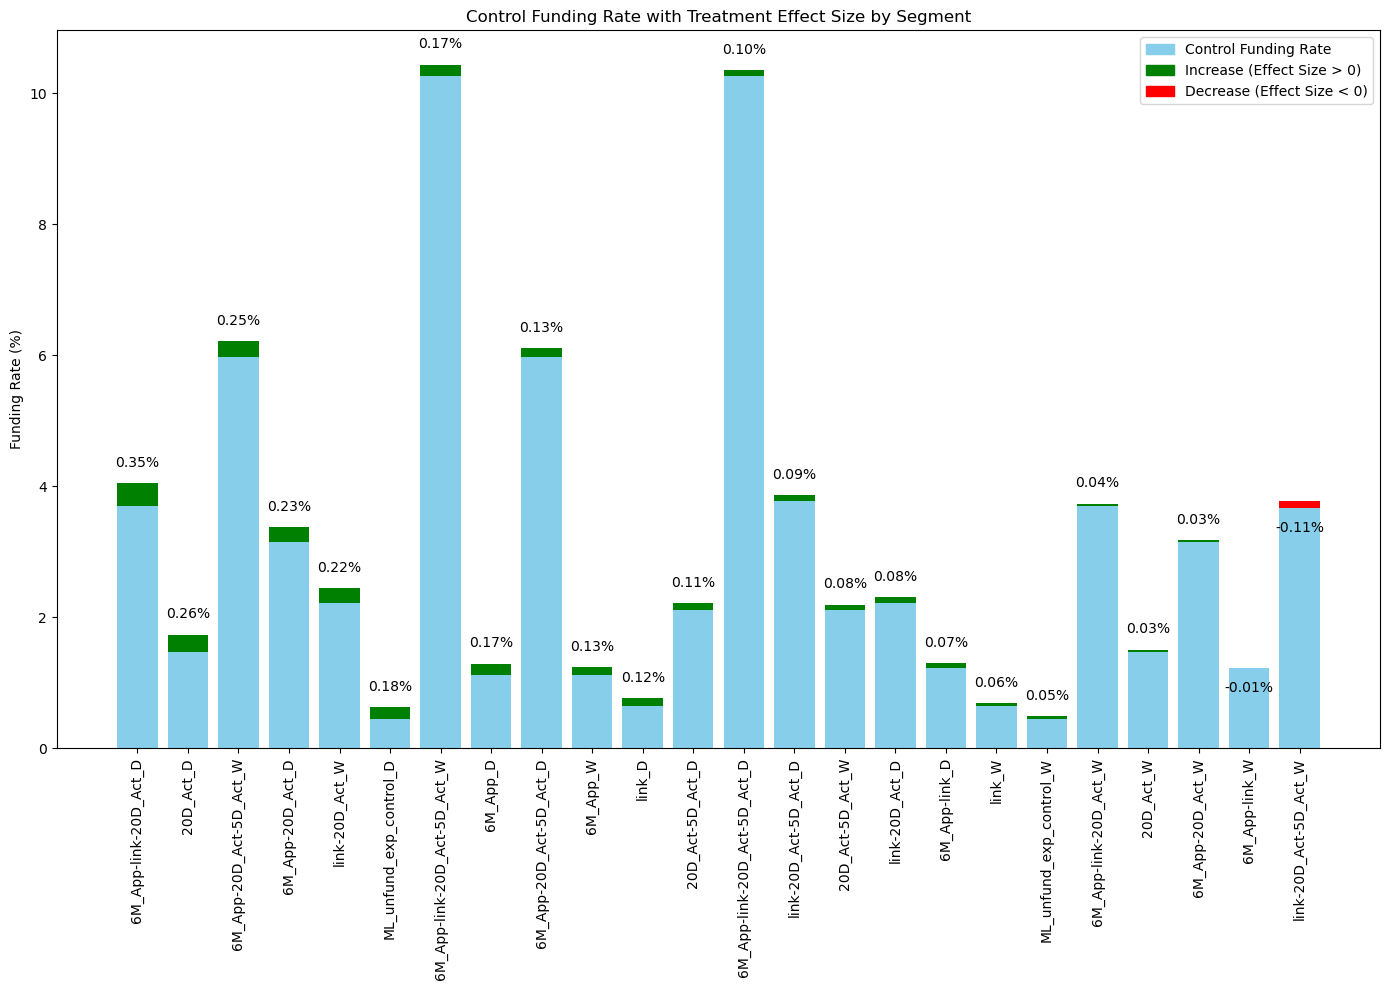

In [94]:
labels = temp['group_name']
x = np.arange(len(labels))
control = temp['funding_rate_in_control'].values
delta = temp['delta_fund_rate'].values
delta_colors = ['green' if d >= 0 else 'red' for d in delta]

fig, ax = plt.subplots(figsize=(14, 10))
ax.bar(x, control, color='skyblue', label='Control Funding Rate')
ax.bar(x, delta, bottom=control, color=delta_colors, label='Treatment Effect (Δ)')

for xi, d, c in zip(x, delta, control):
    y = c + d
    offset = 0.2 if d >= 0 else -0.2
    va = 'bottom' if d >= 0 else 'top'
    ax.text(xi, y + offset, f"{d:.2f}%", ha='center', va=va)

ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90)
ax.set_ylabel('Funding Rate (%)')
ax.set_title('Control Funding Rate with Treatment Effect Size by Segment')
legend_handles = [
    Patch(color='skyblue', label='Control Funding Rate'),
    Patch(color='green', label='Increase (Effect Size > 0)'),
    Patch(color='red',   label='Decrease (Effect Size < 0)'),
]
ax.legend(handles=legend_handles)
plt.tight_layout()
plt.show()

In [95]:
temp =exp_funding_merge_df[exp_funding_merge_df['link_rate']<1].sort_values('delta_link_rate',ascending=False)
temp[["link_rate", "link_rate_in_control",'delta_link_rate']] = temp[["link_rate", "link_rate_in_control",'delta_link_rate']]*100

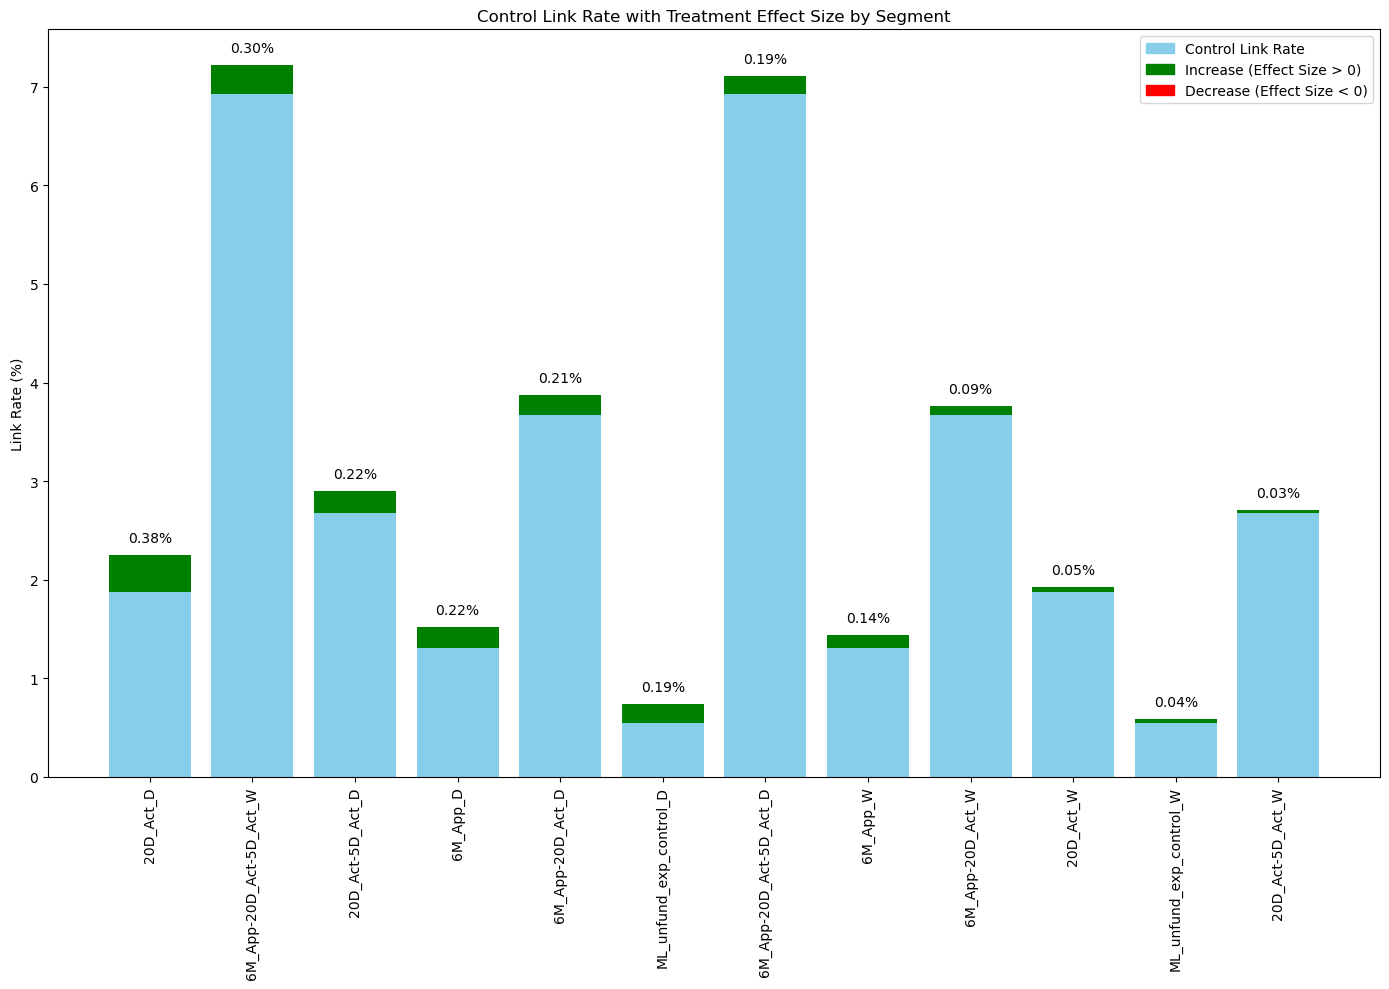

In [ ]:
labels = temp['group_name']
x = np.arange(len(labels))
control = temp['link_rate_in_control'].values
delta = temp['delta_link_rate'].values

# Color mapping for delta: green for increase, red for decrease
delta_colors = ['green' if d >= 0 else 'red' for d in delta]

# Plot
fig, ax = plt.subplots(figsize=(14, 10))
ax.bar(x, control, color='skyblue', label='Control Link Rate')
ax.bar(x, delta, bottom=control, color=delta_colors, label='Treatment Effect (Δ Link Rate)')

# Annotate effect size on each bar
for xi, d, c in zip(x, delta, control):
    y = c + d
    offset = 0.1 if d >= 0 else -0.1
    va = 'bottom' if d >= 0 else 'top'
    ax.text(xi, y + offset, f"{d:.2f}%", ha='center', va=va)

# Formatting
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90)
ax.set_ylabel('Link Rate (%)')
ax.set_title('Control Link Rate with Treatment Effect Size by Segment')
legend_handles = [
    Patch(color='skyblue', label='Control Link Rate'),
    Patch(color='green',   label='Increase (Effect Size > 0)'),
    Patch(color='red',     label='Decrease (Effect Size < 0)')
]
ax.legend(handles=legend_handles)
plt.tight_layout()
plt.show()

# Calculate Time series Metrics


## 1. Pivot email event table to time series (delivery order_0, _1, ..., _9)

In [151]:
email_date_df = user_event_df[['user_uuid','group_name']+PO_number_list]
email_date_df.head()

,user_uuid,group_name,ml_funding_enables_investing,ml_investing_starts_here,ml_explore_the_app_investing,ml_funding_faq,ml_user_clustering_emails_fracs,ml_funding_is_safe,ml_picking_an_investment,ml_investing_101,ml_diversified_portfolio,ml_explore_the_app_list
0,id_2623238174270264636,ML_unfund_exp_control_D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,id_14752263936159847779,ML_unfund_exp_control_D,delivered,delivered,delivered,delivered,delivered,delivered,delivered,delivered,open,delivered
2,id_3723259155072282145,ML_unfund_exp_control_D,delivered,delivered,open,open,open,delivered,delivered,delivered,delivered,open
3,id_9433964625840258739,ML_unfund_exp_control_D,delivered,delivered,delivered,delivered,delivered,delivered,delivered,delivered,delivered,delivered
4,id_17251718038176858460,ML_unfund_exp_control_D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [152]:
PO_number_dict = {}
for d in range(len(PO_number_list)):
    PO_number_dict[d] = PO_number_list[d]

In [153]:
email_event_name_df = sample_exp_df.copy()
for d in range(len(PO_number_list)):
    email_event_name_df['order_'+str(d)] = email_event_name_df['order_'+str(d)].map(PO_number_dict)

email_event_name_df.head()

,user_uuid,group_id,group_name,order_0,order_1,order_2,order_3,order_4,order_5,order_6,order_7,order_8,order_9
0,id_2623238174270264636,0,ML_unfund_exp_control_D,ml_funding_is_safe,ml_investing_101,ml_funding_faq,ml_user_clustering_emails_fracs,ml_diversified_portfolio,ml_explore_the_app_list,ml_funding_enables_investing,ml_investing_starts_here,ml_picking_an_investment,ml_explore_the_app_investing
1,id_14752263936159847779,0,ML_unfund_exp_control_D,ml_funding_faq,ml_investing_starts_here,ml_picking_an_investment,ml_funding_enables_investing,ml_funding_is_safe,ml_explore_the_app_list,ml_user_clustering_emails_fracs,ml_diversified_portfolio,ml_investing_101,ml_explore_the_app_investing
2,id_3723259155072282145,0,ML_unfund_exp_control_D,ml_diversified_portfolio,ml_investing_101,ml_funding_faq,ml_picking_an_investment,ml_investing_starts_here,ml_user_clustering_emails_fracs,ml_explore_the_app_investing,ml_explore_the_app_list,ml_funding_enables_investing,ml_funding_is_safe
3,id_9433964625840258739,0,ML_unfund_exp_control_D,ml_investing_starts_here,ml_diversified_portfolio,ml_funding_enables_investing,ml_picking_an_investment,ml_funding_is_safe,ml_investing_101,ml_user_clustering_emails_fracs,ml_explore_the_app_list,ml_funding_faq,ml_explore_the_app_investing
4,id_17251718038176858460,0,ML_unfund_exp_control_D,ml_picking_an_investment,ml_investing_starts_here,ml_diversified_portfolio,ml_funding_enables_investing,ml_investing_101,ml_funding_faq,ml_funding_is_safe,ml_explore_the_app_investing,ml_explore_the_app_list,ml_user_clustering_emails_fracs


In [154]:
big_table_df = email_event_name_df.merge(email_date_df.drop(columns = ['group_name']),on='user_uuid', how = 'left')
big_table_df.head()

,user_uuid,group_id,group_name,order_0,order_1,order_2,order_3,order_4,order_5,order_6,order_7,order_8,order_9,ml_funding_enables_investing,ml_investing_starts_here,ml_explore_the_app_investing,ml_funding_faq,ml_user_clustering_emails_fracs,ml_funding_is_safe,ml_picking_an_investment,ml_investing_101,ml_diversified_portfolio,ml_explore_the_app_list
0,id_2623238174270264636,0,ML_unfund_exp_control_D,ml_funding_is_safe,ml_investing_101,ml_funding_faq,ml_user_clustering_emails_fracs,ml_diversified_portfolio,ml_explore_the_app_list,ml_funding_enables_investing,ml_investing_starts_here,ml_picking_an_investment,ml_explore_the_app_investing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,id_14752263936159847779,0,ML_unfund_exp_control_D,ml_funding_faq,ml_investing_starts_here,ml_picking_an_investment,ml_funding_enables_investing,ml_funding_is_safe,ml_explore_the_app_list,ml_user_clustering_emails_fracs,ml_diversified_portfolio,ml_investing_101,ml_explore_the_app_investing,delivered,delivered,delivered,delivered,delivered,delivered,delivered,delivered,open,delivered
2,id_3723259155072282145,0,ML_unfund_exp_control_D,ml_diversified_portfolio,ml_investing_101,ml_funding_faq,ml_picking_an_investment,ml_investing_starts_here,ml_user_clustering_emails_fracs,ml_explore_the_app_investing,ml_explore_the_app_list,ml_funding_enables_investing,ml_funding_is_safe,delivered,delivered,open,open,open,delivered,delivered,delivered,delivered,open
3,id_9433964625840258739,0,ML_unfund_exp_control_D,ml_investing_starts_here,ml_diversified_portfolio,ml_funding_enables_investing,ml_picking_an_investment,ml_funding_is_safe,ml_investing_101,ml_user_clustering_emails_fracs,ml_explore_the_app_list,ml_funding_faq,ml_explore_the_app_investing,delivered,delivered,delivered,delivered,delivered,delivered,delivered,delivered,delivered,delivered
4,id_17251718038176858460,0,ML_unfund_exp_control_D,ml_picking_an_investment,ml_investing_starts_here,ml_diversified_portfolio,ml_funding_enables_investing,ml_investing_101,ml_funding_faq,ml_funding_is_safe,ml_explore_the_app_investing,ml_explore_the_app_list,ml_user_clustering_emails_fracs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [156]:
def update_event(in_df):    
    out_df = in_df[['user_uuid','group_name']]
    for d in range(10):
        out_df['order_' + str(d)] = in_df[in_df['order_'+str(d)]]
    return out_df

In [164]:
import time

dates_arr = big_table_df[PO_number_list].to_numpy()
po_to_idx = {po: i for i, po in enumerate(PO_number_list)}
row_idx = np.arange(len(big_table_df))

email_event_TS_df = big_table_df[['user_uuid', 'group_name']].copy()

tic = time.perf_counter()
for d in range(len(PO_number_list)):
    ord_col = f'order_{d}'
    idx = big_table_df[ord_col].map(po_to_idx).to_numpy()
    email_event_TS_df[f'{ord_col}'] = dates_arr[row_idx, idx]
toc = time.perf_counter()

print(f"Run time (vectorized): {toc - tic:.2f} seconds")

Run time (vectorized): 1.78 seconds


In [165]:
email_event_TS_df.head()

,user_uuid,group_name,order_0,order_1,order_2,order_3,order_4,order_5,order_6,order_7,order_8,order_9
0,id_2623238174270264636,ML_unfund_exp_control_D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,id_14752263936159847779,ML_unfund_exp_control_D,delivered,delivered,delivered,delivered,delivered,delivered,delivered,open,delivered,delivered
2,id_3723259155072282145,ML_unfund_exp_control_D,delivered,delivered,open,delivered,delivered,open,open,open,delivered,delivered
3,id_9433964625840258739,ML_unfund_exp_control_D,delivered,delivered,delivered,delivered,delivered,delivered,delivered,delivered,delivered,delivered
4,id_17251718038176858460,ML_unfund_exp_control_D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
email_event_TS_df.to_csv('/content/drive/MyDrive/Email_project/email_event_TS.csv')

In [170]:
day_list = []
for i in range(len(PO_number_list)):
    day_list.append('order_' + str(i))

#delivered_count_df = user_event_df.drop(columns=['user_uuid'])
delivered_count_TS_df = email_event_TS_df.loc[:,['group_name']+day_list]
for e in day_list:
    delivered_count_TS_df[e] = delivered_count_TS_df[e].notnull()
    
delivered_count_TS_df = delivered_count_TS_df.groupby('group_name').sum().reset_index()

In [171]:
delivered_count_TS_df.head()

,group_name,order_0,order_1,order_2,order_3,order_4,order_5,order_6,order_7,order_8,order_9
0,20D_Act-5D_Act_D,19455,19410,19378,19337,19271,19197,19167,19138,19099,19068
1,20D_Act-5D_Act_W,19441,19345,19319,19280,19259,19207,19181,19138,19121,0
2,20D_Act_D,19324,19265,19205,19149,19089,18959,18928,18901,18866,18835
3,20D_Act_W,19301,19176,19088,19051,19018,18946,18921,18888,18863,0
4,6M_App-20D_Act-5D_Act_D,19526,19462,19409,19364,19316,19202,19173,19156,19125,19100


## 2. Check if the experiment has finished.

Apparently, the experiment is no finished as the '*_W' users have not received their last Email (order_9) yet.

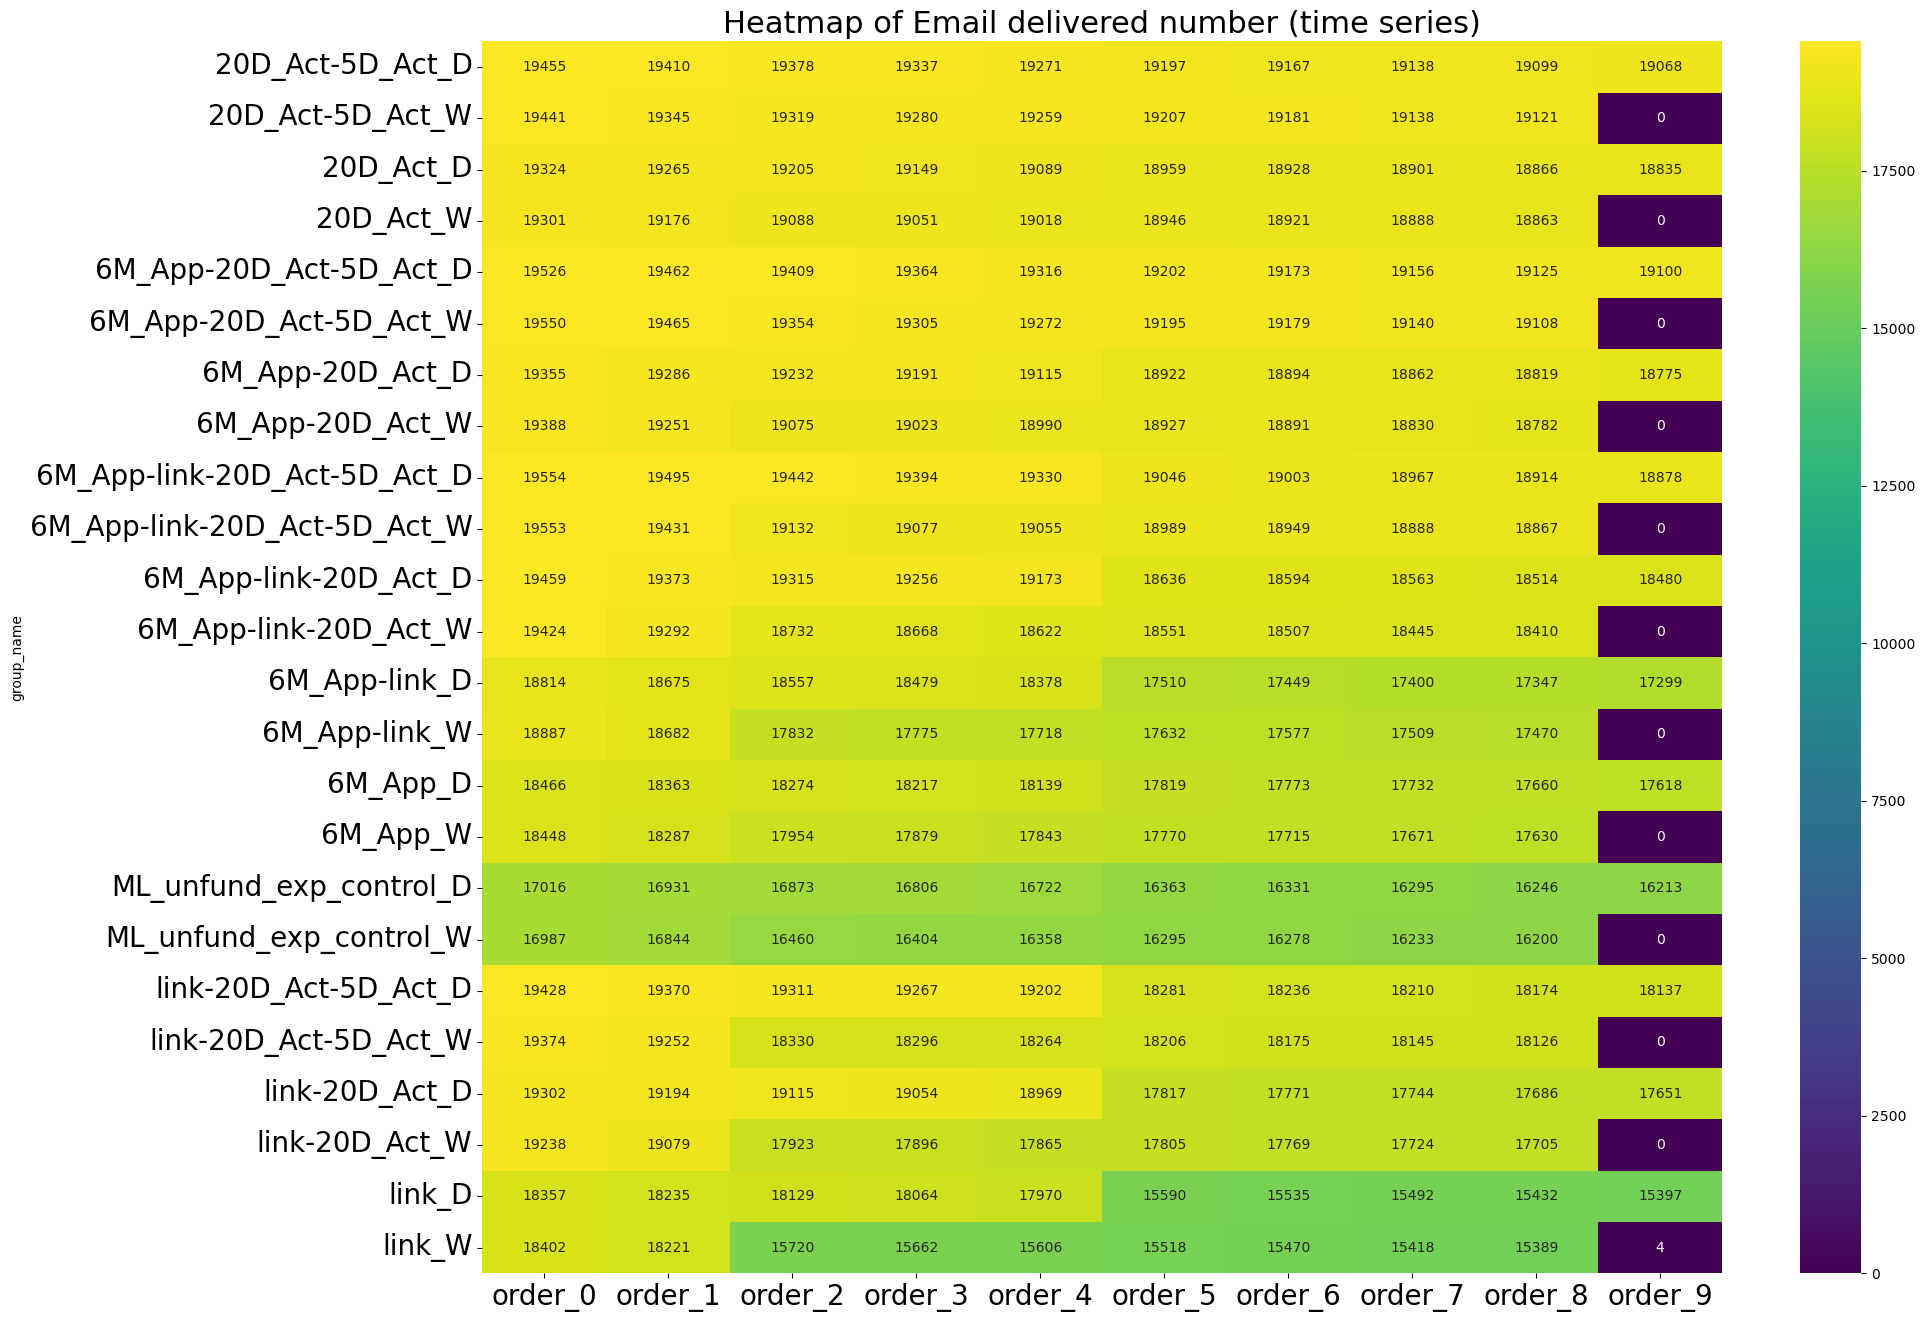

In [172]:

result = delivered_count_TS_df[delivered_count_TS_df['group_name'].str.contains('_D')].set_index('group_name')
result = delivered_count_TS_df.set_index('group_name')
fig, ax = plt.subplots(figsize=(20, 16))
sns.heatmap(result, annot=True, fmt="g", cmap='viridis')

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('Heatmap of Email delivered number (time series)',fontsize=22)
    
    
plt.show()

In [173]:
#open_count_df = user_event_df.drop(columns=['user_uuid'])
open_count_TS_df = email_event_TS_df.loc[:,['group_name']+day_list]
for e in day_list:
    open_count_TS_df[e] = open_count_TS_df[e] == 'open' 
    
open_count_TS_df = open_count_TS_df.groupby('group_name').sum().reset_index()
open_count_TS_df.head()

,group_name,order_0,order_1,order_2,order_3,order_4,order_5,order_6,order_7,order_8,order_9
0,20D_Act-5D_Act_D,3341,3694,3608,3425,3467,3364,2902,3405,3311,3543
1,20D_Act-5D_Act_W,3417,3650,3565,3501,3459,3497,3378,3218,2947,0
2,20D_Act_D,3700,3825,3882,3787,3730,3678,3291,3612,3593,3632
3,20D_Act_W,3637,3886,3826,3746,3601,3533,3597,3374,3229,0
4,6M_App-20D_Act-5D_Act_D,3839,3956,3830,3678,3756,3658,3101,3591,3578,3658


In [174]:
open_rate_TS_df = open_count_TS_df
for e in day_list:
    open_rate_TS_df[e] = open_count_TS_df[e]/delivered_count_TS_df[e]

## 3. Check heatmap for Email open rate according to the order they were sent.

One possible strategy for future Email experiment is to send 2-3 Emails, as the second Email intents to have a higher open rate.

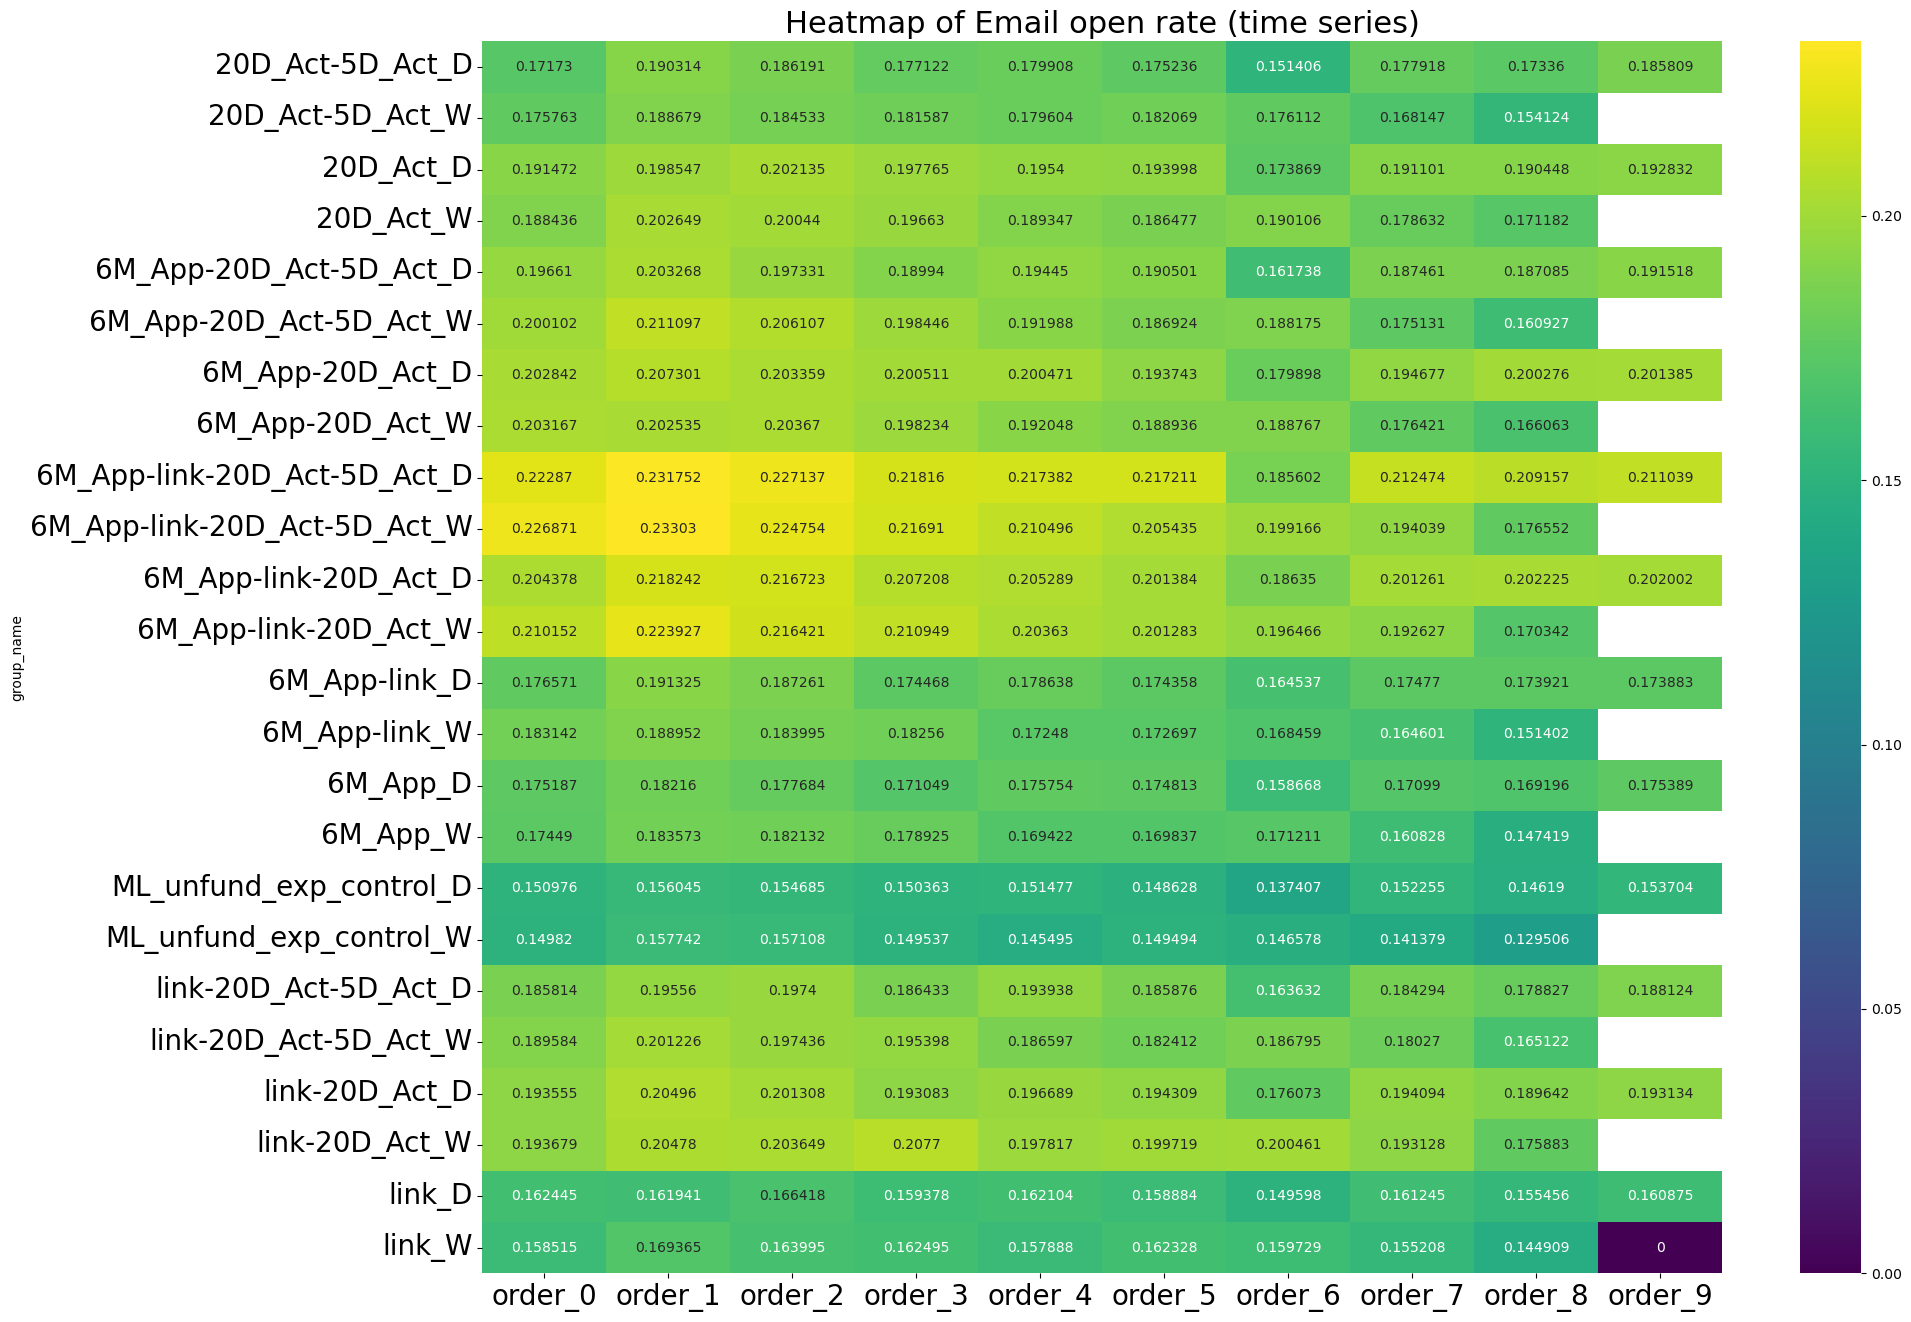

In [175]:
result = open_rate_TS_df[open_rate_TS_df['group_name'].str.contains('_D')].set_index('group_name')
# uncomment after the experiment finishes
result = open_rate_TS_df.set_index('group_name')
fig, ax = plt.subplots(figsize=(20, 16))
sns.heatmap(result, annot=True, fmt="g", cmap='viridis')

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('Heatmap of Email open rate (time series)',fontsize=22)
    
    
plt.show()

# Optional: Funnel analysis

In [ ]:
df = (
    delivered_count_df
    .merge(open_count_df, on='group_name', suffixes=('_del', '_open'))
)

# Compute total delivered & opened per group
df['total_delivered'] = df[[c + '_del' for c in PO_number_list]].sum(axis=1)
df['total_opened']    = df[[c + '_open' for c in PO_number_list]].sum(axis=1)

# open-rate by user segment
df['open_rate'] = df['total_opened'] / df['total_delivered']

open_rate_by_group = df[['group_name', 'open_rate']]
open_rate_by_group


,group_name,open_rate
0,20D_Act-5D_Act_D,0.176917
1,20D_Act-5D_Act_W,0.176766
2,20D_Act_D,0.192787
3,20D_Act_W,0.189364
4,6M_App-20D_Act-5D_Act_D,0.190035
5,6M_App-20D_Act-5D_Act_W,0.191078
6,6M_App-20D_Act_D,0.198487
7,6M_App-20D_Act_W,0.191193
8,6M_App-link-20D_Act-5D_Act_D,0.215386
9,6M_App-link-20D_Act-5D_Act_W,0.209863


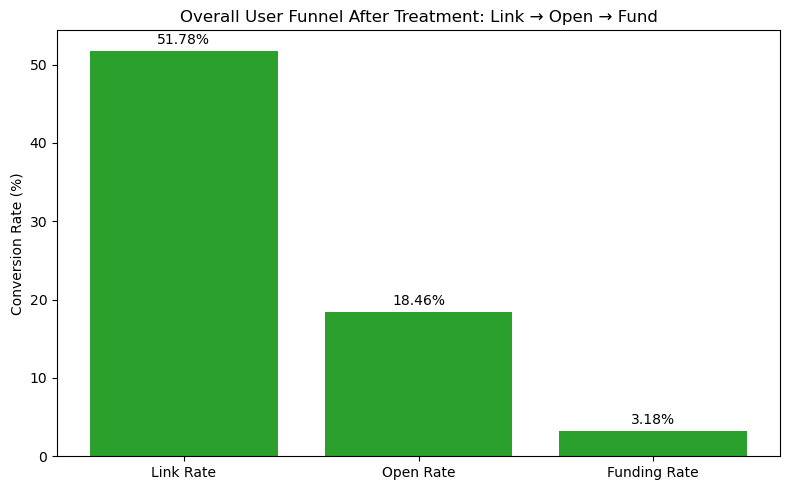

In [144]:
exp_full = exp_funding_merge_df.merge(
    open_rate_by_group[['group_name', 'open_rate']],
    on='group_name'
)

# Compute treatment funnel rates
treat_users     = exp_full['num_users_received_email'].sum()
treat_link_rate = exp_full['num_link'].sum() / treat_users * 100
treat_open_rate = (exp_full['open_rate'] * exp_full['num_users_received_email']).sum() / treat_users * 100
treat_fund_rate = exp_full['num_funded'].sum() / treat_users * 100

# Plot
stages = ['Link Rate', 'Open Rate', 'Funding Rate']
rates  = [treat_link_rate, treat_open_rate, treat_fund_rate]

fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(stages, rates, color='C2')
ax.set_ylabel('Conversion Rate (%)')
ax.set_title('Overall User Funnel After Treatment: Link → Open → Fund')

for bar in bars:
    y = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, y + 0.5, f'{y:.2f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

## Overall Funnel Performance

- **Steep drop‐off at each stage:**  
  - 51.8% of users link an account  
  - 18.5% open the email (36% of those who link)  
  - 3.2% fund (17% of those who open)  

> **In other words:** Out of every 100 targeted users, 52 link, 18 open, and just 3 fund.

## High-Leverage Opportunities

1. **Boost Email Engagement**  
   - Refine subject lines, preview text, and sender personalization  
   - A 5 pp lift in opens (to ~23%) could translate into ~1 pp more in overall funding conversions  

2. **Optimize Post-Open Conversion**  
   - Streamline in-email calls to action and landing-page flows  
   - Introduce targeted incentives or one-click funding buttons  
   - Raising the open→fund rate above 17% compounds end-to-end funnel gains  

> Focusing on these two pinch points will drive the largest incremental impact on funding outcomes.  


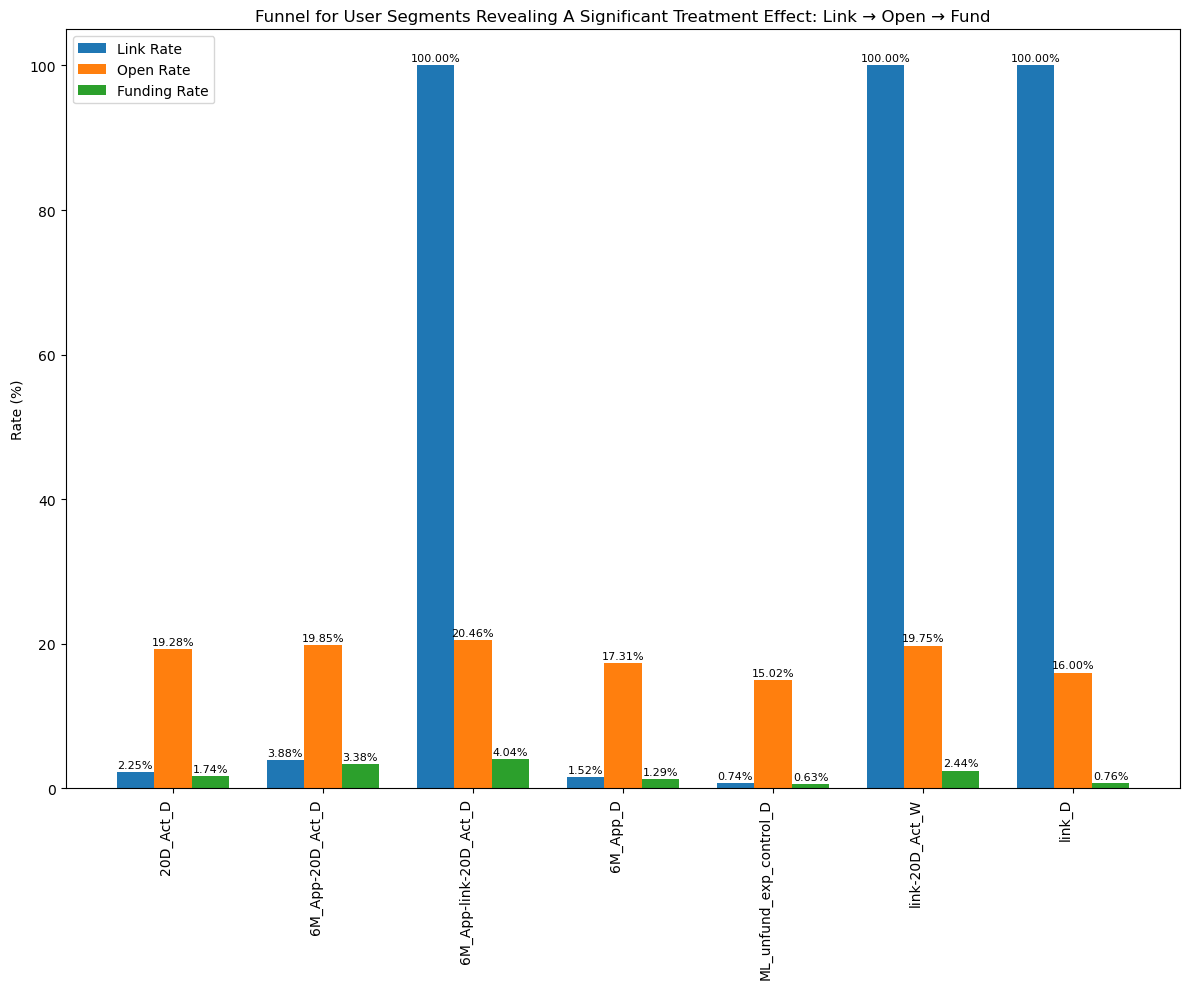

In [150]:
# Filter to only significant treatment groups
exp_full = exp_funding_merge_df.merge(
    open_rate_by_group[['group_name', 'open_rate']],
    on='group_name'
)
sig_df = exp_full[exp_full['significant'] == True]

# Build a small array of funnel rates per segment
labels = sig_df['group_name'].tolist()
rates = []
for _, row in sig_df.iterrows():
    users      = row['num_users_received_email']
    link_rate  = row['num_link'] / users * 100
    open_rate  = row['open_rate'] * 100
    fund_rate  = row['num_funded'] / users * 100
    rates.append([link_rate, open_rate, fund_rate])
rates = np.array(rates)   # shape = (n_segments, 3)

# Plot grouped bar chart
stages = ['Link Rate', 'Open Rate', 'Funding Rate']
x = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots(figsize=(12, 10))
bars1 = ax.bar(x - width, rates[:, 0], width, label='Link Rate')
bars2 = ax.bar(x,         rates[:, 1], width, label='Open Rate')
bars3 = ax.bar(x + width, rates[:, 2], width, label='Funding Rate')

# Add value labels on each bar
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height + 0.3,
            f'{height:.2f}%',
            ha='center', va='bottom', fontsize=8
        )

# Formatting
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90, ha='right')
ax.set_ylabel('Rate (%)')
ax.set_title('Funnel for User Segments Revealing A Significant Treatment Effect: Link → Open → Fund')
ax.legend()
plt.tight_layout()
plt.show()


## Segment-Level Funnel Insights

1. **Dormant Users Open Before They Link**  
   - **ML_unfund_exp_control_D** (accounts >6 months old, unfunded/unlinked) links at only ~0.7% but opens at ~15.0%.  
   - **20D_Act_D** and **6M_App_D** post similar patterns (link < 5%, open ≈ 17–19%).  
   **→ Opportunity:** Leverage this high open engagement with streamlined in-email CTAs and one-click linking flows to convert “returning” users.

2. **Variable Funding Among Fully-Linked Cohorts**  
   - Segments with 100% baseline linking (e.g. **link_D**, **6M_App-link-20D_Act_W**) still open only 16–20%, and fund at just 0.8–4.0%.  
   **→ Opportunity:** For already-linked users, tailor “funding FAQ” content and incentives to lift the open→fund step—especially in cohorts showing the widest funding gaps.

3. **Compounding Engagement Signals Maximizes Lift**  
   - **6M_App-link-20D_Act_D** (newly approved + linked + recent trades) achieves the highest funding rate (~4.04%), **5×** that of dormant users.  
   **→ Opportunity:** Prioritize multi-signal segments with high-value messaging to sustain top-tier funding conversions.

4. **Sharpen Post-Open Conversion Tactics**  
   - Even in best-performing cohorts, only ~17–20% of openers fund.  
   **→ Opportunity:** A/B test more compelling button copy, frictionless funding flows, and targeted incentives to boost open→fund conversion and multiply end-to-end impact.
